<h1>Building Simple a Cat or Dog Classifier with Deep Convolutional Neural Networks</h1>

In this brief study we'll follow these steps:
<ol>
<li>Explore the Example Data of Cats and Dogs</li>
<li>Build and Train a Neural Network to recognize the difference between the two</li>
<li>Evaluate the Training and Validation accuracy</li>
</ol>

<h2>1. Data Exploration</h2>

In [14]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats-dogs.zip

--2021-07-26 17:29:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4004:80d::2010, 2800:3f0:4004:80e::2010, 2800:3f0:4004:802::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4004:80d::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats-dogs.zip’

/tmp/cats-dogs.zip  100%[===================>]  65.43M  14.4MB/s    in 4.6s    

2021-07-26 17:29:32 (14.2 MB/s) - ‘/tmp/cats-dogs.zip’ saved [68606236/68606236]



In [15]:
import os
import zipfile

#os.rename('/tmp/cats_and_dogs_filtered.zip', '/tmp/cats-and-dogs.zip')
localZip = '/tmp/cats-dogs.zip'
localDir = os.getcwd() + '/tmp'

zipRef = zipfile.ZipFile(localZip, 'r')

zipRef.extractall(localDir)
zipRef.close()

The code above extracts the downloaded zip to a folder containing subdirectories for the training and validation datasets, which in turn contain cats and dogs subdirectories.

There are no labels for the images of cats and dogs. The ImageGenerator will automatically label images according to their respective folder. Next, we will define variables to point to these directories.

In [20]:
baseDir = '/tmp/cats_and_dogs_filtered'

trainDir = os.path.join(baseDir, 'train')
validationDir = os.path.join(baseDir, 'validation')

trainCatsDir = os.path.join(trainDir, 'cats')
trainDogsDir = os.path.join(trainDir, 'dogs')

validationCatsDir = os.path.join(validationDir, 'cats')
validationDogsDir = os.path.join(validationDir, 'dogs')

In [21]:
filenamesTrainCats = os.listdir(trainCatsDir)
filenamesTrainDogs = os.listdir(trainDogsDir)

print(filenamesTrainCats[:10])
print(filenamesTrainDogs[:10])

['cat.736.jpg', 'cat.629.jpg', 'cat.485.jpg', 'cat.477.jpg', 'cat.128.jpg', 'cat.466.jpg', 'cat.366.jpg', 'cat.549.jpg', 'cat.226.jpg', 'cat.462.jpg']
['dog.674.jpg', 'dog.762.jpg', 'dog.625.jpg', 'dog.873.jpg', 'dog.243.jpg', 'dog.715.jpg', 'dog.576.jpg', 'dog.183.jpg', 'dog.690.jpg', 'dog.419.jpg']


In [22]:
print("Total of training cat images:", len(os.listdir(trainCatsDir)))
print("Total of training dog images:", len(os.listdir(trainDogsDir)))

print("Total of validation cat images:", len(os.listdir(validationCatsDir)))
print("Total of validation dog images:", len(os.listdir(validationDogsDir)) )

Total of training cat images: 1000
Total of training dog images: 1000
Total of validation cat images: 500
Total of validation dog images: 500


<h2>Visualizing some images from the dataset</h2>

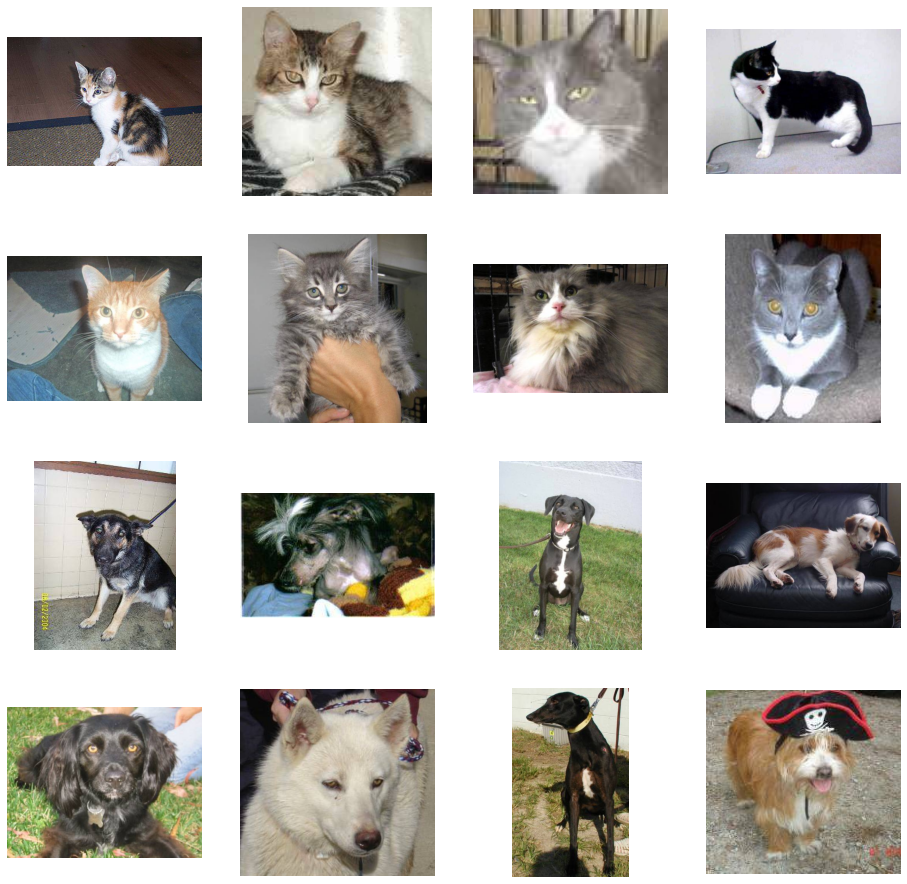

In [28]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows =4
ncols = 4
picIndex = 0

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

picIndex += 8

nextCat = [os.path.join(trainCatsDir, fname) for fname in filenamesTrainCats[picIndex-8:picIndex]]
nextDog = [os.path.join(trainDogsDir, fname) for fname in filenamesTrainDogs[picIndex-8:picIndex]]

for i, imgPath in enumerate(nextCat + nextDog):
    subplt = plt.subplot(nrows, ncols, i + 1)
    subplt.axis('Off')

    img = mpimg.imread(imgPath)
    plt.imshow(img)

plt.show()

We can see that the images come in all shapes and sizes. Furthermore, the animals are in many different positions and lighting conditions. 

<h2>Building a model to recognize cats and dogs</h2>

For the hidden layers, ReLU will be used. This function is linear for values greater than zero, meaning it has a lot of the desirable properties of a linear activation function when training a neural network using backpropagation. Yet, it is a nonlinear function as negative values are always output as zero.

This is a <i>binary classification problem</i>, as our DNN model must learn to identify two distinct categories of objects. Therefore, we will use a sigmoid activation function in the last layer, so that the output will be a scalar between 0 and 1, encoding the probability of belonging to one class or another.

In [31]:
from tensorflow import keras

model = keras.models.Sequential([ 
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

The model summary shows general information about the data process in the network. The "output shape" column tells us how the feature map evolves in each successive layer. Convolution layers reduce the size of features maps by padding, and each maxpooling layer halves the dimensions. We end up with 3,309,729 params for training.

<h2>Training</h2>

Binary crossentropy loss is adequate for our classification problem. The RMSprop is the optimizer of our choice, because it automates learning-rate tuning. Other options would be Adam and Adgrad.

In [34]:
from keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy'])

<h2>Data Preprocessing</h2>

Data generators will be set up to read pictures in the source folders, convert them to `float32` tensors, and feed the pictures along with theirs labels to our neural network. One generator will be fed with training images and the other will receive validation (test) images. The generators will yield batches of 20 images of size 150x150 and their labels (binary).

Before being fed into the neural network, the images pixel values (which vary from 0 to 255) shall be normalized to the `[0,1]` range. In Keras this can be achieved by using the `rescale` parameter in the `keras.preprocessing.image.ImageDataGenerator` class.

This `ImageDataGenerator` class allows us to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainDatagen = ImageDataGenerator(rescale=1.0/255.0)
testDatagen = ImageDataGenerator(rescale=1.0/255.0)

trainGen = trainDatagen.flow_from_directory(trainDir, batch_size=20,
                                            class_mode='binary', target_size=(150,150))

validationGen = testDatagen.flow_from_directory(validationDir, batch_size=20,
                                                class_mode='binary', target_size=(150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<h2>Training</h2>

We will train all 2000 images available for 15 epochs, and validate them on all 1000 images. Four values will be shown per epoch: Loss, Accuracy, Validation Loss and Validation Accuracy.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The Validation accuracy is the measurement with the data that has not been used in training.

In [38]:
import matplotlib.pyplot as plt

def showTrainingHistory(h):
    
    plt.figure(1)
    # summarize history for accuracy
    plt.subplot(211)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training'], loc='lower right')

    # summarize history for loss
    plt.subplot(212)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training'], loc='upper right')

    plt.tight_layout()

    plt.show()

Epoch 1/15
100/100 - 43s - loss: 0.0164 - accuracy: 0.9975 - val_loss: 2.7535 - val_accuracy: 0.7450
Epoch 2/15
100/100 - 46s - loss: 0.0579 - accuracy: 0.9865 - val_loss: 3.2296 - val_accuracy: 0.7420
Epoch 3/15
100/100 - 47s - loss: 0.0403 - accuracy: 0.9915 - val_loss: 2.9547 - val_accuracy: 0.7350
Epoch 4/15
100/100 - 43s - loss: 0.0417 - accuracy: 0.9905 - val_loss: 2.8451 - val_accuracy: 0.7280
Epoch 5/15
100/100 - 43s - loss: 0.0295 - accuracy: 0.9955 - val_loss: 2.2660 - val_accuracy: 0.7420
Epoch 6/15
100/100 - 58s - loss: 0.0364 - accuracy: 0.9920 - val_loss: 2.8205 - val_accuracy: 0.7310
Epoch 7/15
100/100 - 61s - loss: 0.0444 - accuracy: 0.9935 - val_loss: 2.4725 - val_accuracy: 0.7390
Epoch 8/15
100/100 - 44s - loss: 0.0778 - accuracy: 0.9895 - val_loss: 2.1739 - val_accuracy: 0.7430
Epoch 9/15
100/100 - 44s - loss: 0.0360 - accuracy: 0.9935 - val_loss: 3.2939 - val_accuracy: 0.7550
Epoch 10/15
100/100 - 38s - loss: 0.0296 - accuracy: 0.9915 - val_loss: 2.9651 - val_accura

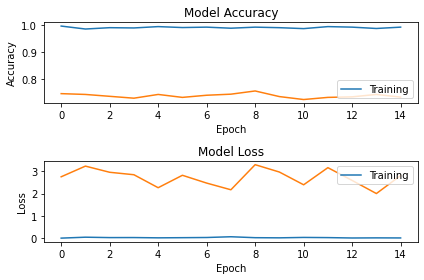

In [55]:
history = model.fit(trainGen, validation_data=validationGen,
                    steps_per_epoch=100, epochs=15,
                    validation_steps=50, verbose=2)

showTrainingHistory(history)

Our model is not performing well. It has a Validation Accuracy of just 75%, and it's probably overfitting, the validation loss increases after 15 epochs. Needs improvements.

In [48]:
#url = input("Please enter an image url: ").strip()

In [47]:
'''from ipywidgets import FileUpload
from IPython.display import display
fn = FileUpload(multiple=True)'''

<h2>Making Predictions</h2>

Now we will send images and run them through the model, so that it will indicate if there is a cat or a dog in the picture.

We're using Unsplash's API to get random images of cats and dogs.


In [56]:
urlList = []

for i in range(1,15):
    urlList.append('https://source.unsplash.com/1200x960/?cat,dog')


[1.6407192e-33]


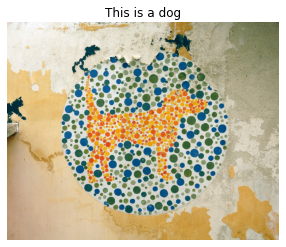

[1.]


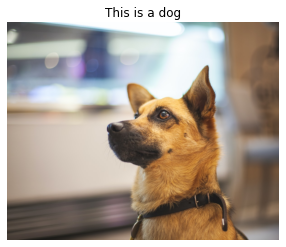

[1.]


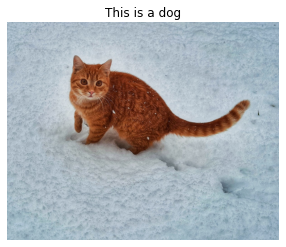

[0.]


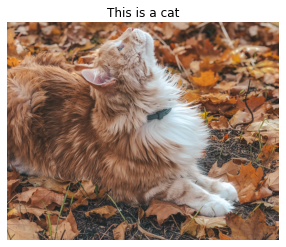

[1.]


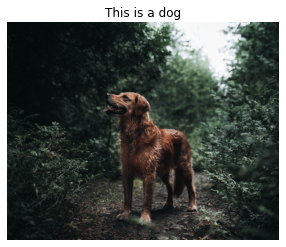

[1.]


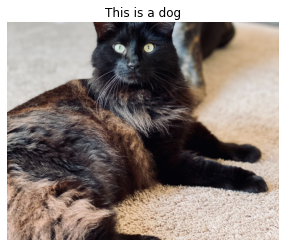

[0.]


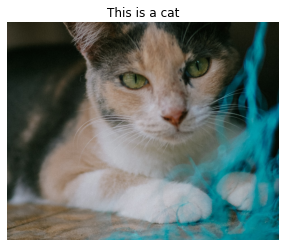

[0.]


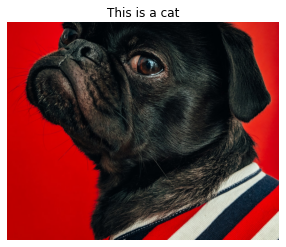

[0.]


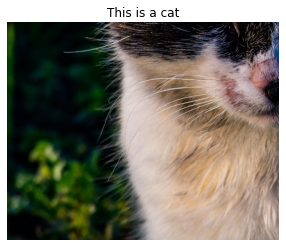

[1.]


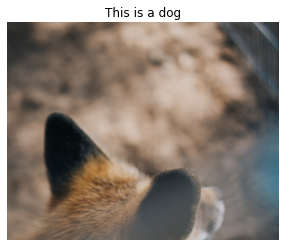

[1.]


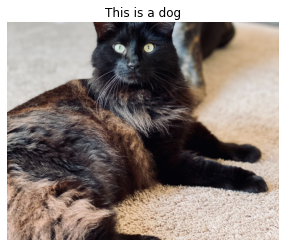

[1.]


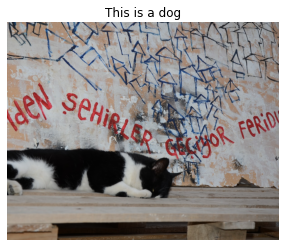

[1.]


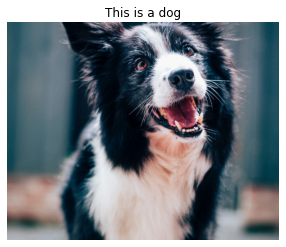

[7.651793e-09]


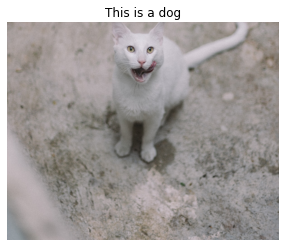

In [59]:
import numpy as np 
from keras.preprocessing import image

from PIL import Image
import requests
import matplotlib.pyplot as plt
import io

if urlList is not None:
    try:
        for url in urlList:
            response = requests.get(url, stream=True)
            img = Image.open(response.raw)

            imgc = img.convert('RGB')

            imgc = imgc.resize((150,150), Image.NEAREST)
            x = image.img_to_array(imgc)

            x = np.expand_dims(x, axis=0)

            images = np.vstack([x])
            classes = model.predict(images, batch_size=10)
            
            print(classes[0])
            if classes[0]>0:
                plt.imshow(img)
                plt.axis('Off')
                plt.title('This is a dog')
                plt.show()
            else:
                plt.imshow(img)
                plt.axis('Off')
                plt.title('This is a cat')
                plt.show()
    except:
        print("An error occured while processing the url.")


So we can see that our neural network still fails in a lot of instances. We need to make adjustments to improve its accuracy.

<h2>Visualizing Intermediate Representations of Pictures</h2>

It's interesting to see how the input image is transformed as it goes through the convolutional neural network. This is a way of finding out what features our ConvNet has learned.

Each row represents the output of a layer, and each image in the row is a specific filter in that output feature map.

<ipython-input-62-45786617a913>:44: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


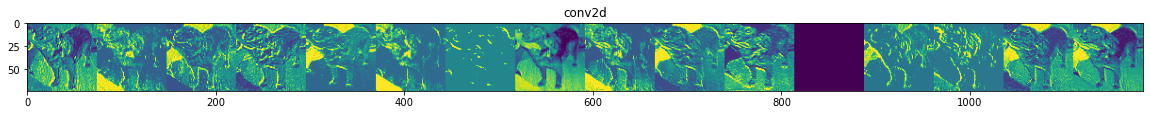

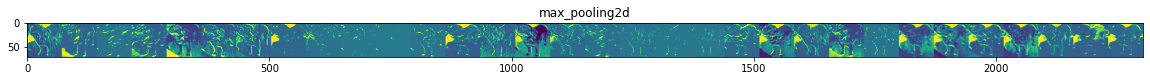

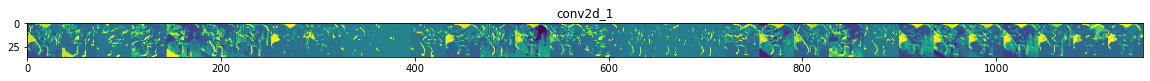

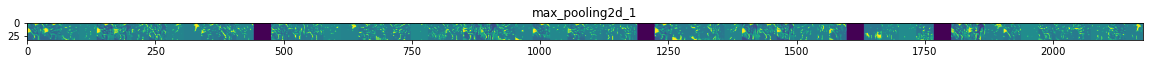

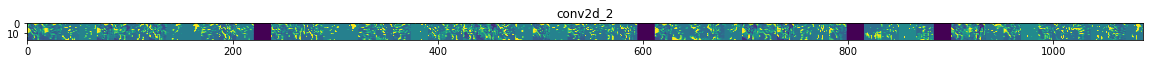

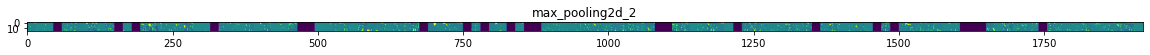

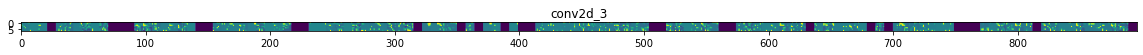

In [62]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

cat_img_files = [os.path.join(trainCatsDir, f) for f in filenamesTrainCats]
dog_img_files = [os.path.join(trainDogsDir, f) for f in filenamesTrainDogs]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    #This matrix tiles the images
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 